In [2]:
import os
from shapely.geometry import Point, Polygon, MultiPolygon
from datetime import datetime
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import sqlite3 as sl
import json
import itertools
import matplotlib.pyplot as plt
import requests

import logging
logging.getLogger().setLevel(logging.INFO) # DEBUG, INFO or WARN

from dotenv import load_dotenv
load_dotenv()

# from isochrones import Isochrones

DROOT = '../1-data/'
os.makedirs(os.path.join(DROOT, '3-interim', 'populationmasks'), exist_ok=True)

In [7]:
%%time
for x in range(1):
    print(x)
    url = "http://localhost:8989/isochrone"
    # url = "http://ec2-3-73-67-166.eu-central-1.compute.amazonaws.com:8989/isochrone"
    params = {
        "point": "52.38075, 4.90084",
        "profile": 'pt',
        "pt.earliest_departure_time": '2023-06-06T08:30:00Z',
        "pt.arrive_by": 'false',
        "locale": 'en-US',
        "pt.profile": "false",
        "pt.access_profile": 'foot',
        "time_limit": 300,
        "reverse_flow": "false"
    }

    response = requests.get(url, params=params)
    res = response.json()

0
CPU times: user 8.67 ms, sys: 4.48 ms, total: 13.1 ms
Wall time: 462 ms


ConnectionError: HTTPSConnectionPool(host='stamen-tiles-a.a.ssl.fastly.net', port=443): Max retries exceeded with url: /terrain/18/134639/86137.png (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x16db85b10>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known'))

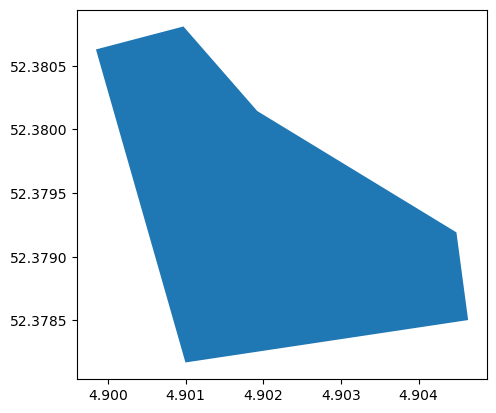

In [9]:

gdf = gpd.GeoDataFrame.from_features(res['polygons'], crs="EPSG:4326")
gdf['geometry'] = gdf.to_crs(gdf.estimate_utm_crs()).buffer(50).simplify(20).to_crs(gdf.crs)
ax = gdf.plot()
ctx.add_basemap(ax, crs=gdf.crs)

In [25]:
cities = pd.read_excel(os.path.join(DROOT, '1-research', 'cities.xlsx'), index_col=0)
cities.head(5)

,City,ctr_name,ctr_lat,ctr_lon,cells,Country,ID_HDC_G0
0,Vienna,Rathaus Wien,48.21080,16.35784,4381,AUT,3027
1,Graz,Hauptplatz Graz,47.06955,15.43383,1168,AUT,3000
2,Brussels,Brussels Town hall,50.84642,4.35232,3747,BEL,2135
3,Berlin,Old City Hall,52.51687,13.41160,5187,DEU,2851
4,Hamburg,Rathaus,53.55035,9.99232,4912,DEU,2531


In [1]:
for i, city in cities.iterrows():
    break;
    print(city.City)
    file = f'{city.ID_HDC_G0}.pcl'
    df = pd.read_pickle(os.path.join(DROOT, '3-interim', 'populationmasks', file))
    gdf = gpd.GeoDataFrame(df)
    
    origins  = enumerate(gdf.centroid.to_crs("EPSG:4326"))
    times    = [5, 15, 25, 35, 45]
    modes_dt = [
        ('driving', 'driving-free', datetime(2023, 5, 2, 8, 30, 37)), 
#         ('driving', 'driving',      datetime(2023, 5, 2, 13, 0, 37)), 
#       ('transit', 'transit-peak', datetime(2023, 5, 2, 8, 30, 37)),
#       ('transit', 'transit',      datetime(2023, 5, 2, 13, 0, 37)), 
#       ('walking', 'walking',      datetime(2023, 5, 2, 8, 30, 37))
    ]
    
    batch      = list(itertools.product(origins, times, modes_dt))
    isochrones = client.get_isochrones_async(city.ID_HDC_G0, batch)

NameError: name 'cities' is not defined

{     "features": [         {             "properties": {                 "fill": "#bf4040",                 "fillOpacity": 0.33,                 "fill-opacity": 0.33,                 "fillColor": "#bf4040",                 "color": "#bf4040",                 "contour": 40,                 "opacity": 0.33,                 "metric": "time"             },             "geometry": {                 "coordinates": [                     [                         6.099667,                         50.787707                     ],                     [                         6.094168,                         50.787442                     ],                     [                         6.093667,                         50.785735                     ],                     [                         6.091525,                         50.785801                     ],                     [                         6.091126,                         50.787401                     ],                     

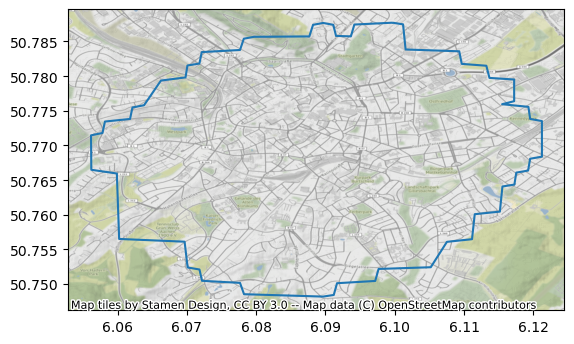

In [11]:
somedata = json.loads(input())
gdf = gpd.GeoDataFrame.from_features(somedata, crs='EPSG:4326')
ax = gdf.plot()
ctx.add_basemap(ax, crs=gdf.crs)

In [18]:
polygons = []
for l1 in coords:
    for l2 in l1['coordinates']:
        polygons.append(Polygon([[e[1], e[0]] for e in l2]))
result = gpd.GeoSeries(MultiPolygon(polygons)).set_crs("EPSG:4326")